<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn 

In [2]:
seaborn.__version__

'0.10.1'

In [3]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [4]:
# Con esto hacemos los gráficos más grandes, adecuados para las presentaciones.
seaborn.set_context(context='talk', font_scale=1.2)

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [5]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [6]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [7]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [8]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [9]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
    dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset = dataset.replace('Latin America & the Caribbean','LatAm')
dataset.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,LatAm,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0


In [10]:
dataset.dtypes

year                        int64
ISO_code                   object
countries                  object
region                     object
pf_identity_legal         float64
pf_identity_sex_male      float64
pf_identity_sex_female    float64
pf_identity_sex           float64
pf_identity_divorce       float64
pf_identity               float64
pf_score                  float64
pf_rank                   float64
ef_score                  float64
ef_rank                   float64
hf_score                  float64
hf_rank                   float64
dtype: object

# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.

In [11]:
df = dataset
df = df.drop(['ISO_code', 'countries', 'region'], axis=1) # drop non numeric variables
max_row = df.max()
min_row = df.min()
ranges = max_row - min_row
range_df = pandas.DataFrame({'Min' : min_row,'Max' : max_row, "Range" : ranges})
range_df

,Min,Max,Range
year,2008.00,2017.00,9.00
pf_identity_legal,0.00,10.00,10.00
pf_identity_sex_male,0.00,10.00,10.00
pf_identity_sex_female,0.00,10.00,10.00
pf_identity_sex,0.00,10.00,10.00
pf_identity_divorce,0.00,10.00,10.00
pf_identity,0.00,10.00,10.00
pf_score,2.22,9.56,7.34
pf_rank,1.00,162.00,161.00
ef_score,2.58,9.11,6.53


  2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 

RESPUESTA: (Pablo)
Vamos a usar los datos a través del tiempo comparando dato con dato y en los casos en que ay que sacar conclusiones respecto a intervalos especificos vamos a usar el promedios.


2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.

In [12]:
# mean, median and standard deviation for the world
# Ser consistente como tratamos los intervalos de tiempo ????  
grouped = dataset.groupby(['region'])
LatAm = grouped.get_group('LatAm')
descriptive_df = pandas.DataFrame({'index' : ['pf_identity_mean','pf_identity_std','pf_identity_median', \
                                              'hf_score_mean','hf_score_std','hf_score_median'], \
                                   'LatAm' : [ LatAm.pf_identity.mean(), \
                                              LatAm.pf_identity.std(), \
                                              LatAm.pf_identity.median(), \
                                              LatAm.hf_score.mean(), \
                                              LatAm.hf_score.std(), \
                                              LatAm.hf_score.median()], \
                                   "World" : [ dataset.pf_identity.mean(), \
                                              dataset.pf_identity.std(), \
                                              dataset.pf_identity.median(), \
                                              dataset.hf_score.mean(), \
                                              dataset.hf_score.std(), \
                                              dataset.hf_score.median()]})
descriptive_df.set_index('index') # make it a little prettier

,LatAm,World
index,,
pf_identity_mean,8.582171,7.280649
pf_identity_std,1.875832,3.181577
pf_identity_median,10.000000,8.800000
hf_score_mean,7.036977,6.978214
hf_score_std,0.634897,1.056239
hf_score_median,7.020000,6.900000


  * ¿Tiene sentido calcular la moda? *RESPUESTA*
  * ¿Cómo pueden sanearse los valores faltantes? *RESPUESTA*
  * ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos? RESPUESTA

## OUTLIERS
Dos formas de identificarlos:
* usando 1.5*IQR
* usando 2.5 * standard deviation from the mean

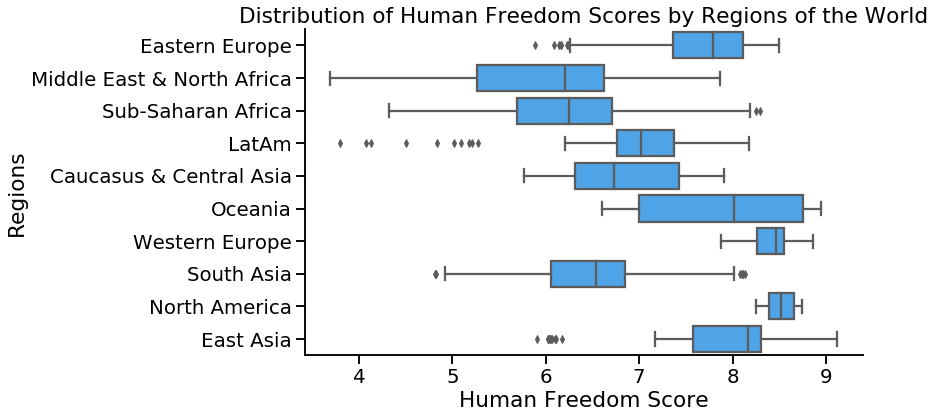

In [13]:
# The best way to quickly visualize outliers is with the box and whiskers plot (grafico de caja)
plt.figure(figsize=(10,6))
seaborn.boxplot(data=dataset,
                x='hf_score', y= 'region',
                color=BLUE)
plt.ylabel('Regions')
plt.xlabel('Human Freedom Score')
plt.title('Distribution of Human Freedom Scores by Regions of the World')
seaborn.despine()

As indicated by the black diamods situated left of the left whisker, LatAm has many outliers, or values 

### Finding outliers method 1: usando 1.5*IQR

In [14]:
# Outliers World ~~ [ 0.25= Q1, 0.5 = Q2 (median), 0.75= Q3 ]
quartiles = dataset.hf_score.quantile([0.25,0.5,0.75]).round(2)
quartiles = quartiles.tolist()
IQR = quartiles[2]-quartiles[0] #calculate the interquartile range
1.5*IQR # for all outliers will be this many away from the median

2.3999999999999995

In [15]:
# Outliers LatAm~~ [ 0.25= Q1, 0.5 = Q2 (median), 0.75= Q3 ]
quartiles_latam = LatAm.hf_score.quantile([0.25,0.5,0.75])
quartiles_latam = quartiles_latam.tolist()
IQR_latam = quartiles_latam[2]-quartiles_latam[0] #calculate the interquartile range
print("Any value ",1.5*IQR_latam," above the third quartile or below the first quartile it would be considered an outlier.") # for all outliers will be this many away from the median

Any value  0.9225000000000003  above the third quartile or below the first quartile it would be considered an outlier.


### Finding outliers method 2: usando 2.5 * standard deviation from the mean

In [16]:
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    mask_score_outlier = (
        numpy.abs(interesting_col - interesting_col.mean()) <= (2.5 * interesting_col.std()))
    return dataset[mask_score_outlier]

# World outliers
data = clean_outliers(dataset, "hf_score").hf_score
print("Filas removidas", len(dataset) - len(data))
print("Human Freedom máximo considerado", data.max())
print("Human Freedom minimo considerado", data.min())

Filas removidas 93
Human Freedom máximo considerado 9.12
Human Freedom minimo considerado 4.34


In [17]:
# Outliers in Latin America y Caribe
data2 = clean_outliers(LatAm, "hf_score").hf_score
print("Filas removidas", len(LatAm) - len(data2))
print("Human Freedom máximo considerado", data2.max())
print("Human Freedom minimo considerado", data2.min())

Filas removidas 12
Human Freedom máximo considerado 8.18
Human Freedom minimo considerado 6.21


Al final no sacamos los outliers... ?  --------- Brandon ------

## 2. Agregación de datos  - Pablo & Karen

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.

{2008: 7.721985815602838, 2009: 7.721985815602837, 2010: 7.48562091503268, 2011: 7.4529411764705875, 2012: 7.4529411764705875, 2013: 7.367515923566879, 2014: 7.416352201257862, 2015: 6.964150943396228, 2016: 6.87037037037037, 2017: 6.496913580246914} 

 {2008: 7.078014184397164, 2009: 7.08304964539007, 2010: 7.03529411764706, 2011: 7.014575163398693, 2012: 6.978039215686275, 2013: 6.970191082802549, 2014: 6.949937106918237, 2015: 6.922264150943398, 2016: 6.892716049382716, 2017: 6.887962962962963}


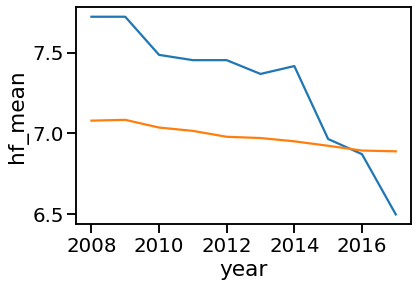

In [18]:

years = list(set(dataset['year'].to_list()))
years = list(numpy.sort(years))
pf_data = {}
hf_data = {}
def get_means():
    for year in years:
        grouped = dataset.groupby(['year'])
        year_data = grouped.get_group(year)
        pf_identities= year_data['pf_identity'].to_list()
        pf_identities=[x for x in pf_identities if str(x) != 'nan']
        pf_identity_mean=numpy.mean(pf_identities)
        pf_data[year]=pf_identity_mean
        
        hf_scores = year_data['hf_score'].to_list()
        hf_scores=[x for x in hf_scores if str(x) != 'nan']
        hf_score_mean = numpy.mean(hf_scores)
        hf_data[year]=hf_score_mean
    
    return pf_data, hf_data


pf_data, hf_data = get_means()
print(pf_data,"\n\n", hf_data)
pf = pandas.DataFrame(pf_data.items(), columns=['year', 'pf_mean'])
hf = pandas.DataFrame(hf_data.items(), columns=['year', 'hf_mean'])

#plotting
ax=seaborn.lineplot(x="year", y="pf_mean", data=pf)
bx=seaborn.lineplot(x="year", y="hf_mean", data=hf)
#el amarillo es bx 


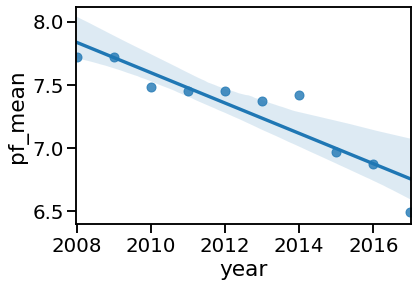

In [19]:
global_pf = seaborn.regplot(x="year",y="pf_mean",data = pf)


2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?


Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

['Caucasus & Central Asia', 'East Asia', 'Eastern Europe', 'LatAm', 'Middle East & North Africa', 'North America', 'Oceania', 'South Asia', 'Sub-Saharan Africa', 'Western Europe']


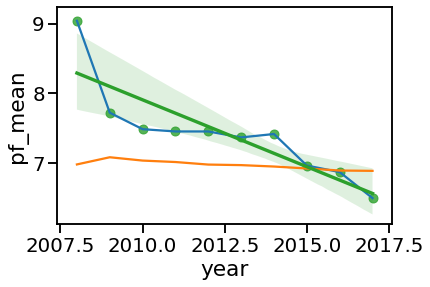

In [20]:
regions = list(set(dataset['region'].to_list()))
regions = list(numpy.sort(regions))
print(regions)
plots=[]
region = 'LatAm'
by_region = dataset.groupby(['region']).get_group(region)

#esto puede ser get_means_by(my_filter, region)
#y en el groupby haces str(my_filter)
def get_means_by_region(region):
    #para una region
    by_region = dataset.groupby(['region']).get_group(region)
    for year in years:
        grouped = by_region.groupby(['year'])
        year_data = grouped.get_group(year)
        pf_identities= year_data['pf_identity'].to_list()
        pf_identities=[x for x in pf_identities if str(x) != 'nan']
        pf_identity_mean=numpy.mean(pf_identities)
        pf_data[year]=pf_identity_mean
        
        hf_scores = year_data['hf_score'].to_list()
        hf_scores=[x for x in hf_scores if str(x) != 'nan']
        hf_score_mean = numpy.mean(hf_scores)
        hf_data[year]=hf_score_mean
    
        pf = pandas.DataFrame(pf_data.items(), columns=['year', 'pf_mean'])
        hf = pandas.DataFrame(hf_data.items(), columns=['year', 'hf_mean'])

        return pf, hf
        
#el amarillo es bx
pf_cca, hf_cca = get_means_by_region('Caucasus & Central Asia')
pf_cca_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_cca)
hf_cca_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_cca)
#thanks, i hate it
caa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_cca)



TOD0: Cleanup... usar grid, que tengan la misma escala para que las gráficas sean analizables una al lado de la otra.
Inspiración:
<code
countries = ['Argentina', 'Brazil', 'Mexico', 'Bolivia',
             'Uruguay', 'Peru', 'Colombia', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "ef_score", color=BLUE)
g.map(seaborn.lineplot, "year", "pf_score", color=RED)
g.set(xlim=(2008, 2016))

print('Puntajes de libertad para América Latina');
>

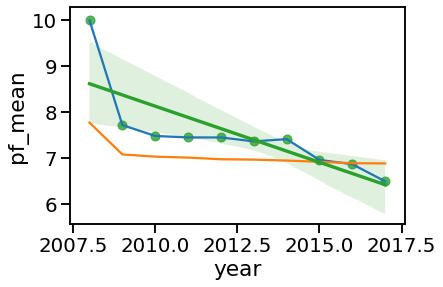

In [21]:
pf_ea, hf_ea = get_means_by_region('East Asia')
pf_ea_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ea)
hf_ea_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ea)
ea_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ea)


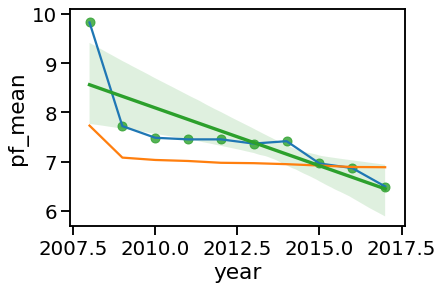

In [22]:
pf_ee, hf_ee = get_means_by_region('Eastern Europe')
pf_ee_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ee)
hf_ee_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ee)
ee_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ee)


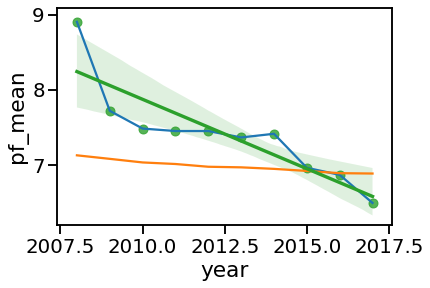

In [23]:
pf_lat, hf_lat = get_means_by_region('LatAm')
pf_lat_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_lat)
hf_lat_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_lat)
lat_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_lat)


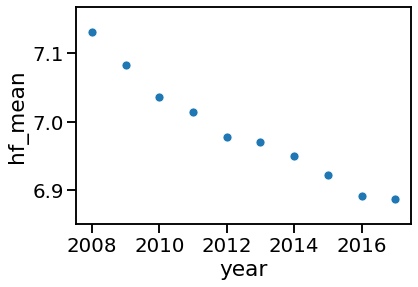

In [24]:
hf_lat_scat = seaborn.scatterplot(x="year", y="hf_mean", data=hf_lat)

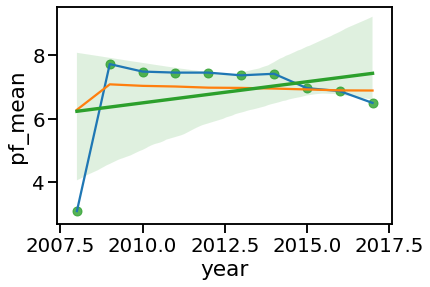

In [25]:
pf_me, hf_me = get_means_by_region('Middle East & North Africa')
pf_me_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_me)
hf_me_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_me)
me_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_me)


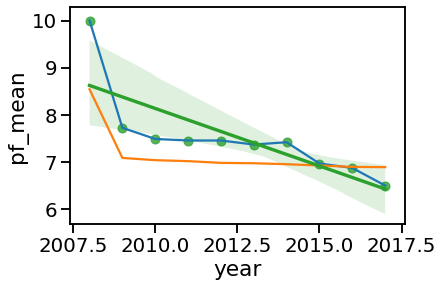

In [26]:
pf_na, hf_na = get_means_by_region('North America')
pf_na_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_na)
hf_na_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_na)
na_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_na)


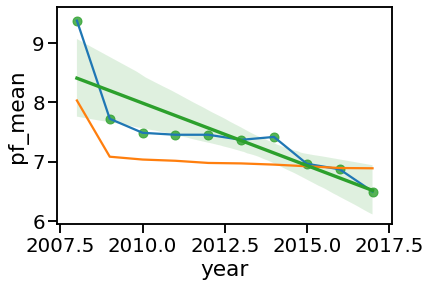

In [27]:
pf_oc, hf_oc = get_means_by_region('Oceania')
pf_oc_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_oc)
hf_oc_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_oc)
oc_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_oc)


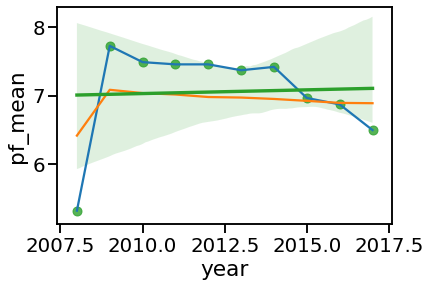

In [28]:
pf_sa, hf_sa = get_means_by_region('South Asia')
pf_sa_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_sa)
hf_sa_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_sa)
sa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_sa)


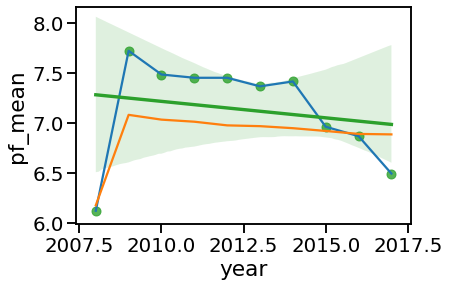

In [29]:
pf_saa, hf_saa = get_means_by_region('Sub-Saharan Africa')
pf_saa_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_saa)
hf_saa_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_saa)
saa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_saa)


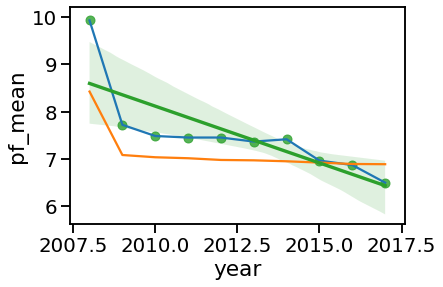

In [30]:
pf_we, hf_we = get_means_by_region('Western Europe')
pf_we_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_we)
hf_we_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_we)
we_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_we)


#Teniendo en cuenta lo que vemos en los gráficos por región vs el gráfico de tendencias global
#vemos que si bien no todas las regiones en particular decrecen como la pendiente de la tendencia global indica
#la mayoría sí decrece.

#3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica 
#para tratar de explicar la tendencia de la variable *pf_identity* en la región. 
#¿Cómo seleccionarion los países relevantes a esa tendencia?

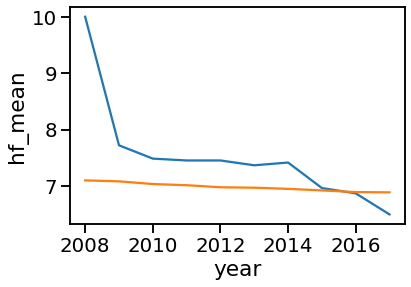

In [31]:
#venezuela, chile, uruguay, argentina. porque son los que me gustan 
#seaborn.regplot(x="year",y="hf_mean",data = hf_lat)
def get_means_by_country(country):
    #para una region
    by_region = dataset.groupby(['countries']).get_group(country)
    for year in years:
        grouped = by_region.groupby(['year'])
        year_data = grouped.get_group(year)
        pf_identities= year_data['pf_identity'].to_list()
        pf_identities=[x for x in pf_identities if str(x) != 'nan']
        pf_identity_mean=numpy.mean(pf_identities)
        pf_data[year]=pf_identity_mean
        
        hf_scores = year_data['hf_score'].to_list()
        hf_scores=[x for x in hf_scores if str(x) != 'nan']
        hf_score_mean = numpy.mean(hf_scores)
        hf_data[year]=hf_score_mean
    
        pf = pandas.DataFrame(pf_data.items(), columns=['year', 'pf_mean'])
        hf = pandas.DataFrame(hf_data.items(), columns=['year', 'hf_mean'])

        return pf, hf
        
#el amarillo es bx
pf_arg, hf_arg = get_means_by_country('Argentina')
pf_arg_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_arg)
hf_arg_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_arg)



Puntajes de libertad para América Latina


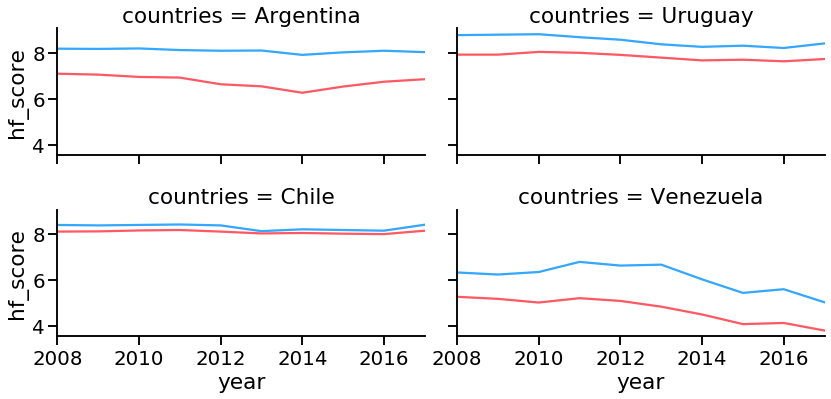

In [32]:
#no entendemos este código
countries = ['Argentina','Uruguay', 'Chile', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "pf_score", color=BLUE)
g.map(seaborn.lineplot, "year", "hf_score", color=RED)
g.set(xlim=(2008, 2017))

print('Puntajes de libertad para América Latina');

Tendencias de los puntajes de libertad para América Latina


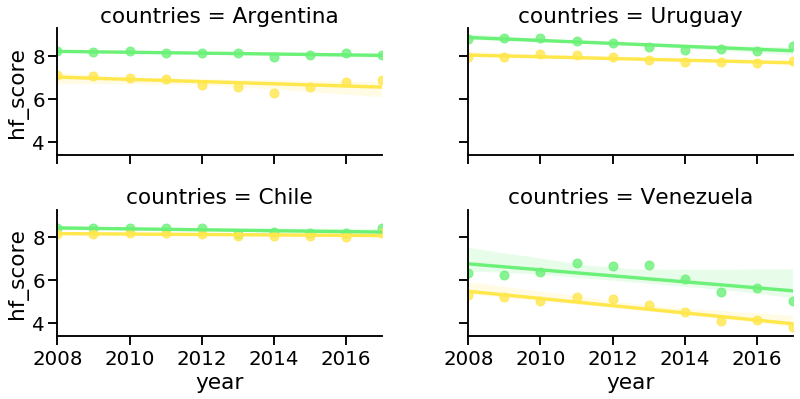

In [33]:
#no entendemos este código
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.regplot,"year", "pf_score", color=GREEN)
g.map(seaborn.regplot,"year", "hf_score", color=YELLOW)
g.set(xlim=(2008, 2017))

print('Tendencias de los puntajes de libertad para América Latina');

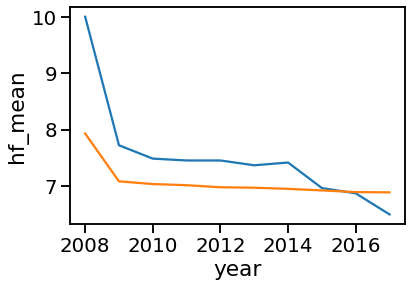

In [34]:
pf_ur, hf_ur = get_means_by_country('Uruguay')
pf_ur_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ur)
hf_ur_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ur)
#ur_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ur)


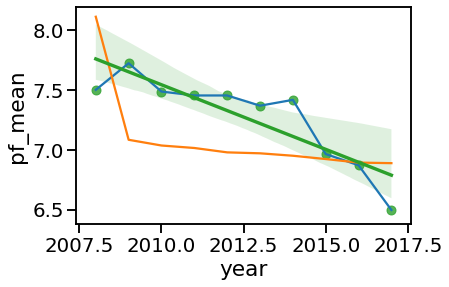

In [35]:
pf_ch, hf_ch = get_means_by_country('Chile')
pf_ch_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ch)
hf_ch_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ch)
ch_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ch)


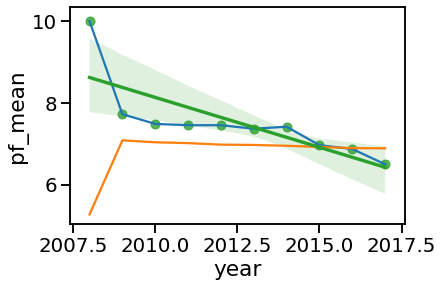

In [36]:
pf_vz, hf_vz = get_means_by_country('Venezuela')
pf_vz_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_vz)
hf_vz_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_vz)
vz_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_vz)


## 3. Distribuciones - Karen y Pablo 
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todo el conjunto de valores disponibles para esa region en estos gráficos?


https://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/

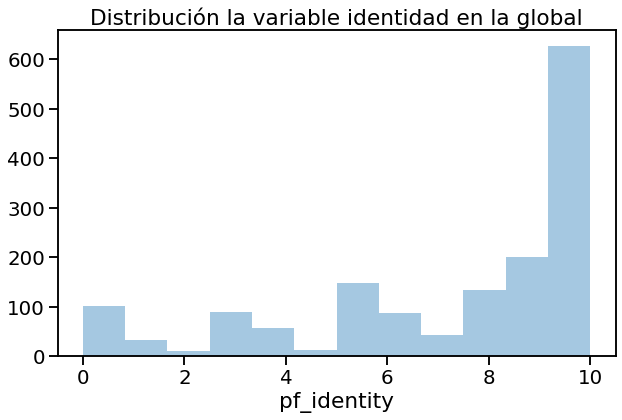

In [37]:
plt.figure(figsize=(10,6))
plt.title('Distribución la variable identidad en la global')
seaborn.distplot(dataset.pf_identity,kde=False)


#### Distribución
Pareciera tener distribución exponencial.
La muestra está concentrada hacia la derecha, es decir, hay una probabilidad más alta, dada una muestra, de encontrarse con una pf_identity con valor alto

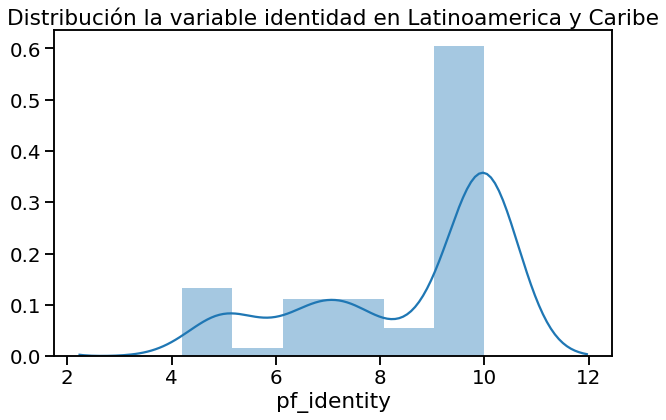

In [38]:
latam = dataset.groupby(['region']).get_group('LatAm')
plt.figure(figsize=(10,6))
plt.title('Distribución la variable identidad en Latinoamerica y Caribe')
seaborn.distplot(latam.pf_identity, kde=True)

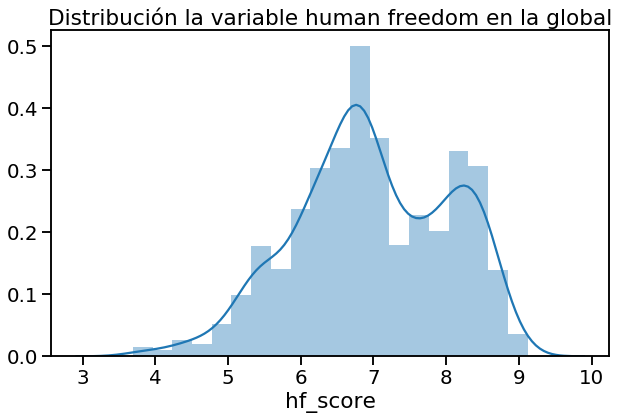

In [39]:
plt.figure(figsize=(10,6))
plt.title('Distribución la variable human freedom en la global')
seaborn.distplot(dataset.hf_score)

#Pareciera ser Chi Cuadrado

#### Distribución
Pareciera tener distribución Chi cuadrado.
Presenta dos copas, un máximo global y uno local.
La muestra está concentrada levemente hacia la derecha, el máximo global se da para un hf_score de aprox 7,
siendo el otro pico alrededor del hf_score aprox 8.

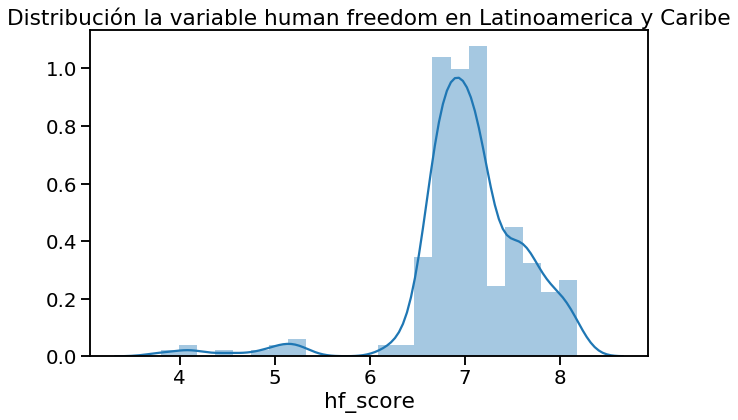

In [40]:
latam = dataset.groupby(['region']).get_group('LatAm')
plt.figure(figsize=(10,6))
plt.title('Distribución la variable human freedom en Latinoamerica y Caribe')
seaborn.distplot(latam.hf_score)

#También pareciera ser Chi cuadrado

#### Distribución
Pareciera tener distribución Chi cuadrado.
Presenta una copita, cerca de hf_score=7
En comparación a la distribución global, presenta un solo pico, y es mucho más pronunciado

## 4. Correlaciones y Relaciones -  Gonzalo y Flor

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_identity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?

Text(0.5, 1.08, 'Correlación entre variables. Año 2017.')

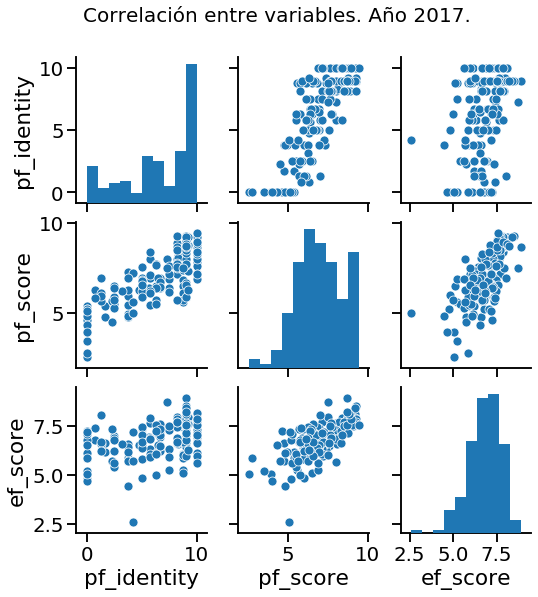

In [41]:
# Realizamos los gráficos para un año particular ya que el dataset completo es muy denso
datos1=dataset[dataset.year==2017]
columnasimpor=['pf_identity','pf_score','ef_score']
datos=datos1[columnasimpor]
m = seaborn.pairplot(datos);
m.fig.suptitle('Correlación entre variables. Año 2017.', fontsize=20, y=1.08)

Los conjuntos de datos están relacionados de manera positiva entre ellos, lo cual era esperable en una primera instancia para los valores de  pf_score y pf_identity, ya la primera es calculada a partir de la segunda. Se observa además que el indicador de libertad económica (ef_score) se vincula de manera positiva con el indicador de libertad personal (pareciese ser una relación bastante fuerte), que es lo esperable por los autores del informe. No pareciese, al menos visualmente, que la liberar económica tuviese una vinculación fuerte con el indicador de liberar de identidad(pf_identity).
La utilización de este tipo de gráficos en variables como pf_identity es discutible, dado que los puntajes que pueden obtener las variables que lo componen están acotados a un número finito de valores (en general no más de 3), con lo cual existe una cantidad finita de resultados posibles para pf_identity, por lo que quizas un gráfico de barras sería más adecuado para definir las categorías.

2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.

Text(0.6, 1.05, 'Correlación entre variables. Año 2017')

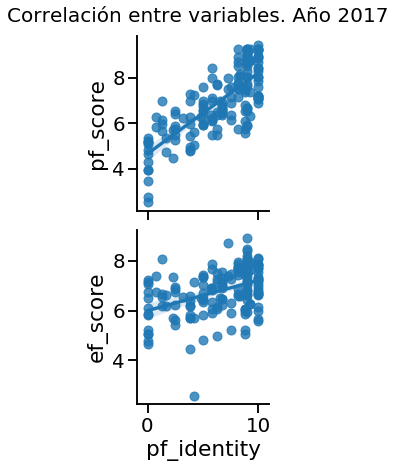

In [42]:
#Graficamos las dos relaciones en el mismo grafico para facilitar la visualización.
g = seaborn.PairGrid(datos, x_vars=["pf_identity"], y_vars=["pf_score", "ef_score"], height=3)
g.map(seaborn.regplot)
g.fig.suptitle('Correlación entre variables. Año 2017', fontsize=20, y=1.05, x=0.6)
# Para pf_identity vs pf_score se podría utilizar una regresión logística?

En primera instancia se observa que existe una relación positiva entre pf_identity y pf_score, que es lo esperado dado que es un componente del indice, como se mencionó anteriormente. Con respecto a la ef_score, si bien la función genera una linea de regresión con pendiente positiva, visualmente no parecieran tener una gran asociación entre los conjuntos. Probablemente excluyendo algunos valores extremos la recta de regresión sería anulada. Un análisis más pronfundo requeriría la utilización de algún indicador de la bondad del ajuste de la regresión.
Sacar conclusiones a partir de este tipo de análisis entendemos no sería lo más adecuado en vista que el tipo de relación que existe entre las variables no sería lineal si no probablemente del tipo logística. 

3. Convertir estas variables en categóricas, es decir, a partir de pf_identity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.qcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.

## (!!!)
Tenemos que decidir si vamos a trabaja con todos los datos en esta sección o solo con un año (en la anterior se utilizó solo un año y no ser consistentes en la metodología de análisis es incorrecto). Utilizando todos los datos encuentro compleja la visualización de todas las relaciones por que los mapas de calor no son claros.
Al momento de realizar la división de según categorías la elección que tomamos fue agrupar utilizando los cuartiles, encontrandonos con un inconveniente en lo referente a la variable pf_identity. Dado que la misma no es una variable continua si no discreta, el tercer y cuarto cuartil son coincidentes. (esto es posible?). por lo que tuvimos que realizar la agrupación con las siguientes cotas: low= 0,25, medium: 0,5, hig: 1. Esto puede estar generando inconvenientes con la separación en los conjuntos con más continuidad en los valores.

In [43]:
#calculamos el pf_score_segment para el año 2017

quartiles_pf = dataset.pf_score.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_pf = quartiles_pf.tolist()
pf_score_segment = pandas.cut(x=datos['pf_score'], bins=[quartiles_pf[0], quartiles_pf[1],quartiles_pf[2],quartiles_pf[4]], labels=["low","medium","high"], include_lowest=True)
print(pf_score_segment)

#calculamos el ef_score_segment para el año 2017

quartiles_ef = dataset.ef_score.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_ef = quartiles_ef.tolist()
ef_score_segment = pandas.cut(x=datos['ef_score'], bins=[quartiles_ef[0], quartiles_ef[1],quartiles_ef[2],quartiles_ef[4]], labels=["low","medium","high"], include_lowest=True)
print(ef_score_segment)

#calculamos el pf_identity_segment para el año 2017

quartiles_pfid = dataset.pf_identity.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_pfid = quartiles_pfid.tolist()
pf_identity_segment = pandas.cut(x=datos['pf_identity'], bins=[quartiles_pfid[0], quartiles_pfid[1],quartiles_pfid[2],quartiles_pfid[4]], labels=["low","medium","high"], include_lowest=True)
print(pf_identity_segment)

0        high
1         low
2         low
3        high
4        high
        ...  
157       low
158    medium
159       low
160       low
161       low
Name: pf_score, Length: 162, dtype: category
Categories (3, object): [low < medium < high]
0        high
1         low
2         low
3         low
4        high
        ...  
157       low
158    medium
159       low
160    medium
161       low
Name: ef_score, Length: 162, dtype: category
Categories (3, object): [low < medium < high]
0      medium
1         low
2         low
3        high
4      medium
        ...  
157       low
158      high
159       low
160    medium
161       low
Name: pf_identity, Length: 162, dtype: category
Categories (3, object): [low < medium < high]


Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables

Text(54.5, 0.5, 'Libertad Personal')

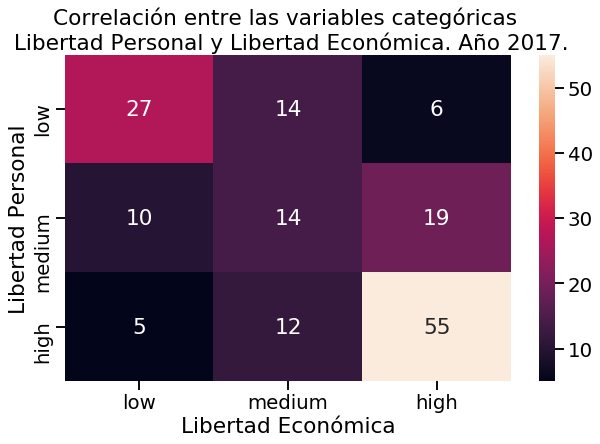

In [44]:
#Correlación visual entre pf_score_segment y ef_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(pf_score_segment, ef_score_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad Personal y Libertad Económica. Año 2017.")
plt.xlabel("Libertad Económica")
plt.ylabel("Libertad Personal")

Text(54.5, 0.5, 'Libertad Económica')

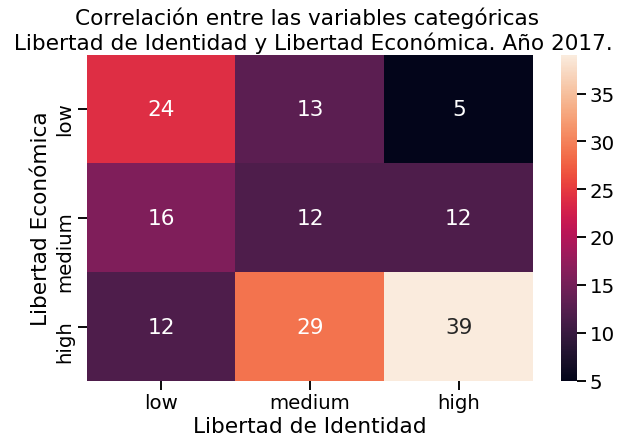

In [45]:
#Correlación visual entre pf_identity_segment y ef_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(ef_score_segment, pf_identity_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad de Identidad y Libertad Económica. Año 2017.")
plt.xlabel("Libertad de Identidad")
plt.ylabel("Libertad Económica")

Text(54.5, 0.5, 'Libertad Personal')

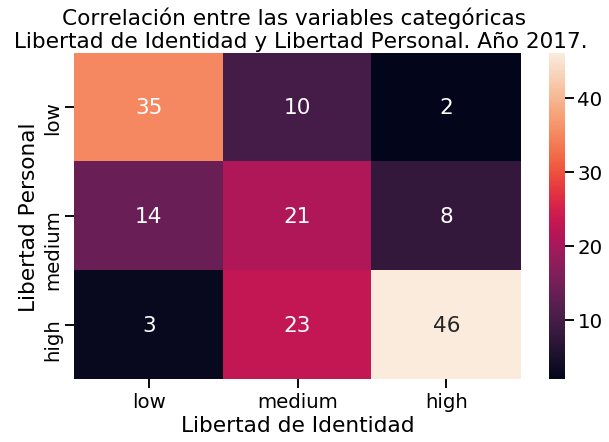

In [46]:
#Correlación visual entre pf_identity_segment y pf_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(pf_score_segment, pf_identity_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad de Identidad y Libertad Personal. Año 2017.")
plt.xlabel("Libertad de Identidad")
plt.ylabel("Libertad Personal")

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

En este apartado tenemos  que ponernos de acuerdo en que distribución entendemos tienen los datos. Me parece que lo más adeacuado es definir un año para trabajar o utilizar todo el dataset pero con los datos segmentados. Este punto lo tenenemos que adecuar a lo que hagamos en 1.3.
El problema de trabajar con todo el dataset es que estamos trabajando con series de tiempo, y las variables están correlacionadas (los valores pasados de las variables probablemente influyan en los valores presentes, salvo cambios bruscos). Por eso tenemos que hacer un corte transversal y trabajar de a años.
Realizando unas modificaciones temporales en el código noté que al filtrar por el año 2017 las variables tienen una distribución con dos picos. Si bien esto nos aleja de la normal, podriamos tomar como H0 que la distribución es normal dado que solo tenemos una MODA (valor con probabilidad más alta). ¿Coincide con la mediana o en cuanto se desvía?

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 

In [47]:
#Calculamos el coeficiente de correlación entre las variables pf_identity y pf_score. Año 2017.

from scipy.stats import spearmanr
coef, p = spearmanr(datos.pf_identity, datos.pf_score)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.759
Las variables están correlacionadas (rechazar H0) p=0.000


In [48]:
#Calculamos el coeficiente de correlación entre las variables pf_identity y ef_score. Año 2017.

from scipy.stats import spearmanr 
coef, p = spearmanr(datos.pf_identity, datos.ef_score)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación }

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.422
Las variables están correlacionadas (rechazar H0) p=0.000


Como puede verse, en el caso de las variables pf_identity y pf_score existe una correlación positiva. Es una correlación cercana a 1 (0,759), lo cual tiene sentido por la forma en que se calcula pf_identity. Podemos decir que hay evidencia de que están correlacionadas a través del p-valor (al ser menor que el nivel de significación, se rechaza la hipótesis nula de independencia de variables).
En el caso de las variables pf_identity y ef_score se obtuvo un coeficiente de correlación positivo de 0,422. Esto significa que la relación no es tan fuerte como la del otro par de variables. Cuando se compara el p-valor con el nivel de significación se tiene que hay evidencia para rechazar la hipótesis nula. Por esta razón se concluye que las variables están correlacionadas.

4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

In [70]:
datos2 = datos1.assign(pf_identity_segment = pf_identity_segment, pf_score_segment = pf_score_segment, ef_score_segment = ef_score_segment)
datos2.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,pf_identity_segment,pf_score_segment,ef_score_segment
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0,medium,high,high
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0,low,low,low
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0,low,low,low
3,2017,ARG,Argentina,LatAm,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,high,high,low
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0,medium,high,high


In [79]:
#Calculamos el coeficiente de correlación entre las variables region y pf_score_segment. Año 2017.

from scipy.stats import spearmanr
coef, p = spearmanr(datos2.region, datos2.pf_score_segment)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.088
Las variables no están correlacionadas (no puede rechazar H0) p=0.263


In [63]:
#Calculamos el coeficiente de correlación entre las variables region y ef_score_segment. Año 2017.

from scipy.stats import spearmanr
coef, p = spearmanr(datos2.region, datos2.ef_score_segment)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.022
Las variables no están correlacionadas (no puede rechazar H0) p=0.784


In [64]:
#Calculamos el coeficiente de correlación entre las variables region y pf_identity_segment. Año 2017.

from scipy.stats import spearmanr
coef, p = spearmanr(datos2.region, datos2.pf_identity_segment)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: -0.027
Las variables no están correlacionadas (no puede rechazar H0) p=0.736


In [65]:
exp1 = pandas.crosstab(datos2.region, datos2.pf_score_segment)
exp1

pf_score_segment,low,medium,high
region,,,
Caucasus & Central Asia,2,2,2
East Asia,1,0,5
Eastern Europe,1,2,19
LatAm,1,12,13
Middle East & North Africa,16,2,1
North America,0,0,2
Oceania,0,1,3
South Asia,6,9,2
Sub-Saharan Africa,20,15,7


In [75]:
from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(exp1)
g, p

(107.41538343743797, 9.51225088874374e-15)

In [66]:
exp2 = pandas.crosstab(datos2.region, datos2.ef_score_segment)
exp2

ef_score_segment,low,medium,high
region,,,
Caucasus & Central Asia,1,1,4
East Asia,0,1,5
Eastern Europe,1,6,15
LatAm,3,9,14
Middle East & North Africa,8,5,6
North America,0,0,2
Oceania,0,2,2
South Asia,4,7,6
Sub-Saharan Africa,25,9,8


In [76]:
from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(exp2)
g, p

(67.18071419955541, 1.3471480937338988e-07)

In [67]:
exp3 = pandas.crosstab(datos2.region, datos2.pf_identity_segment)
exp3

pf_identity_segment,low,medium,high
region,,,
Caucasus & Central Asia,0,4,2
East Asia,0,2,4
Eastern Europe,0,7,15
LatAm,5,12,9
Middle East & North Africa,17,2,0
North America,0,0,2
Oceania,1,0,3
South Asia,6,10,1
Sub-Saharan Africa,23,16,3


In [77]:
from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(exp3)
g, p

(112.79796173374365, 9.460276137592545e-16)

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?